# Part 1) Introduction to Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # optional for PDFs or confidence intervals

## 1.1 - Why Do Kalman Filters Exist?

**<ins>What problem were Kalman filters trying to solve?</ins>**

In real-world systems — like satellites, aircraft, self-driving cars, and even phones — we often want to know something important about the system’s state. For example:

- A spacecraft’s position and velocity
- An aircraft’s pitch or roll angle
- A robot’s location on a map

But here’s the problem:

We can’t measure the state perfectly.  
Sensors are noisy.  
Our mathematical models are not perfect either.  
We only get measurements at discrete time intervals.

So we face two big challenges:

1. **Estimating the current state when we can't see it directly**
2. **Filtering out the noise from measurements to make good decisions**

<ins>What the Kalman filter solves</ins>:

The Kalman Filter (KF) provides a mathematical way to:

- Predict the system’s next state using a model (e.g., physics equations)
- Update the prediction using real sensor measurements
- Combine both optimally, by weighting each source of information based on how much noise or uncertainty it contains

It does all this recursively, in real time, and with minimal memory.

**<ins>Why it's so important</ins>**:

- It's computationally efficient (only needs the current state and the latest measurement)
- It gives the best possible estimate under Gaussian noise assumptions
- It’s foundational in control systems, navigation, GNSS, robotics, computer vision, and more

In short: The Kalman filter helps us know what’s really going on when all we have is noisy, partial, or uncertain data.

## 1.2 - Basic Statistics

### 1.2.1 - Mean, Expected Value, Variance, Standard Deviation

#### Descriptive Stats

For example, we have 10-value list as the **entire population**, so we can compute for **descriptive statistics** that will describe the trend within the population.

Take note of the `ddof` parameter when using numpy:

- Use `ddof=0` to divide by $N$, not $N - 1$
- This gives the **true variance** and **standard deviation** of the dataset

If we later treat the same dataset as a **sample** from a larger population, we would compute **inferential statistics** instead, using $ddof=1$ to divide by $N - 1$ (Bessel’s correction).

The **mean** of a population is:

$$
\mu = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

The **population variance** is:

$$
\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2
$$

The **population standard deviation** is:

$$
\sigma = \sqrt{\sigma^2}
$$

In [2]:
# Step 1: Define a simple dataset
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Step 2: Compute descriptive statistics
mean = np.mean(data)
variance = np.var(data, ddof=0)     
std_dev = np.std(data, ddof=0)       

print("Data:       ", data)
print("Mean:       ", mean)
print("Variance:   ", variance)
print("Std Dev:    ", std_dev)

Data:        [0 1 2 3 4 5 6 7 8 9]
Mean:        4.5
Variance:    8.25
Std Dev:     2.8722813232690143


Since this dataset is a **complete population**, the computed mean:

$$
\mu = \frac{1}{10} \sum_{i=0}^{9} x_i = 4.5
$$

is **exactly equal** to the expected value:

$$
\mathbb{E}[X] = 4.5
$$

In general, $\mathbb{E}[X]$ is a theoretical average over all possible values a random variable $X$ can take. If we only have a sample, then the sample mean is just an **estimate** of this expected value.

#### Inferential Stats

Now we treat the same dataset as a **sample** drawn from a larger population.  
This allows us to compute **inferential statistics**, which are used to estimate the characteristics of the full population.

Take note of the `ddof` parameter when using numpy:

- Use `ddof=1` to divide by $N - 1$, not $N$
- This applies **Bessel’s correction**, which corrects the bias in estimating population variance from a sample

The **sample mean** is:

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

The **sample variance** is:

$$
s^2 = \frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})^2
$$

The **sample standard deviation** is:

$$
s = \sqrt{s^2}
$$

In [3]:
# Step 1: Define a simple dataset (treated as full population)
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Step 2: Compute descriptive statistics for the full dataset
mean = np.mean(data)
variance = np.var(data, ddof=0)      # population variance
std_dev = np.std(data, ddof=0)       # population std dev

print("Full Data (Population): ", data)
print("Population Mean:        ", mean)
print("Population Variance:    ", variance)
print("Population Std Dev:     ", std_dev)

# Step 3: Inferential statistics — draw a sample from the population
np.random.seed(42)  # for reproducibility
sample = np.random.choice(data, size=5, replace=False)

sample_mean = np.mean(sample)
sample_variance_unbiased = np.var(sample, ddof=1)  
sample_std_unbiased = np.std(sample, ddof=1)
sample_variance_biased = np.var(sample, ddof=0)  
sample_std_biased = np.std(sample, ddof=0)

print("\nSample Populstion (n=4):            ", sample)
print("Sample Mean:                        ", sample_mean)
print("Sample Variance (unbiased):         ", sample_variance_unbiased)
print("Sample Std Dev (unbiased):          ", sample_std_unbiased)
print("Sample Variance (biased):           ", sample_variance_biased)
print("Sample Std Dev (biased):            ", sample_std_biased)

Full Data (Population):  [0 1 2 3 4 5 6 7 8 9]
Population Mean:         4.5
Population Variance:     8.25
Population Std Dev:      2.8722813232690143

Sample Populstion (n=4):             [8 1 5 0 7]
Sample Mean:                         4.2
Sample Variance (unbiased):          12.7
Sample Std Dev (unbiased):           3.5637059362410923
Sample Variance (biased):            10.16
Sample Std Dev (biased):             3.1874754901018454


We compute both the **biased** and **unbiased** sample variance and standard deviation.

- The **biased estimator** (using `ddof=0`) divides by $n$, and tends to **underestimate** the population variance.
- The **unbiased estimator** (using `ddof=1`) applies **Bessel's correction**, dividing by $n - 1$ to correct for the bias introduced by using the sample mean.

This correction ensures that:

$$
\mathbb{E}[s^2] = \sigma^2
$$

on average across many samples.

As shown above, the sample variance and standard deviation with `ddof=1` are slightly larger — and often more accurate — than those computed with `ddof=0`.

### 1.2.2 - Normal Distribution

A **normal distribution** (also called Gaussian) is a continuous probability distribution  
that is symmetric about its mean, with a bell-shaped curve.

We generate 1000 random values from a normal distribution with:

- Mean: $\mu = 5$
- Standard deviation: $\sigma = 2$

We plot a histogram of the sampled data and overlay the **true probability density function (PDF)**:

$$
f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \, \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

This visualizes the **empirical shape** of the distribution and compares it to the **ideal** bell curve.
The **area under the curve is 1**, which corresponds to the total probability ($P=1$).  
This means the PDF tells us how probability is **distributed** around the mean.

For a normal distribution:

- **68%** of the data lies within $\mu \pm 1\sigma$  of the mean  
- **95%** lies within $\mu \pm 2\sigma$  
- **99.7%** lies within $\mu \pm 3\sigma$

This rule illustrates how most values are concentrated near the mean,  
with probability tapering off symmetrically in both directions.

These intervals help us understand **uncertainty and confidence** when modeling or estimating data using a normal distribution.

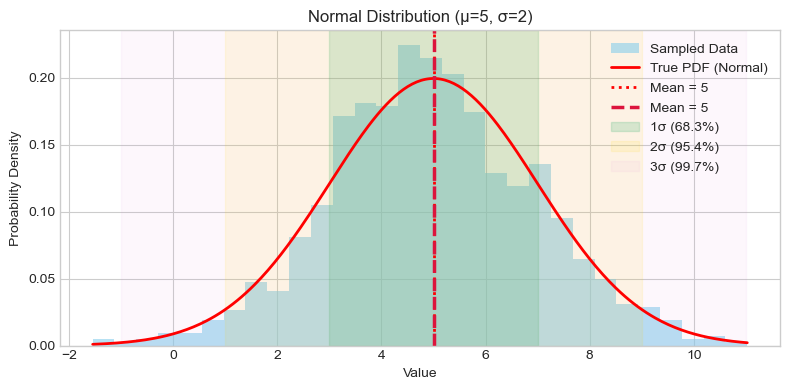

In [8]:
# Use a visually appealing style
plt.style.use('seaborn-v0_8-whitegrid')

# Step 1: Generate random data from a normal distribution
mu = 5      # mean
sigma = 2   # standard deviation
data = np.random.normal(loc=mu, scale=sigma, size=1000)

# Step 2: Plot histogram and overlay the true PDF
plt.figure(figsize=(8, 4))
count, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Sampled Data')

# Step 3: Plot theoretical PDF
x = np.linspace(min(bins), max(bins), 300)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r', lw=2, label='True PDF (Normal)')

# Step 4: Add mean and sigma intervals
plt.axvline(mu, color='r', linestyle='dotted', linewidth=2, label=f'Mean = {mu}')

# Step 5: Add mean line
plt.axvline(mu, color='crimson', linestyle='--', linewidth=2.5, label=f'Mean = {mu}')

# Step 6: Shade sigma intervals
plt.axvspan(mu - sigma, mu + sigma, alpha=0.2, color='mediumseagreen', label='1σ (68.3%)')
plt.axvspan(mu - 2*sigma, mu + 2*sigma, alpha=0.1, color='gold', label='2σ (95.4%)')
plt.axvspan(mu - 3*sigma, mu + 3*sigma, alpha=0.05, color='orchid', label='3σ (99.7%)')

plt.title(f"Normal Distribution (μ={mu}, σ={sigma})")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.2.3 - Random Variables

### 1.2.4 - Estimate, Accuracy and Precision

## 1.3 - The alpha-beta-gamma filter